# **Dimensionality Reduction & Predictive Analysis - for Primary Dataset ("Cleaned-Movies-Primary.csv")**

### Techniques used: 
### * Dimensionality Reduction - Principle Component Analysis (PCA)
### * Predictive Analysis - Linear Regression

**Dimesionality Reduction Rationale- We are using Principle Component Analysis (PCA) method for the following reasons:** 
* PCA is ideal for transforming high dimensional datasets into low dimension of features, while retaining as much important information as possible
* a common use-case for PCA is movie recommendation system, like our project
* PCA helps in reducing load on computation resources and preventing overfitting



In [ ]:
# check for correlation analysis first, amongst all variables :

In [2]:
import pandas as pd

# Load your dataset
file_path = 'Cleaned-Reduced-Movie-Primary.csv'
df = pd.read_csv(file_path)

# Determine correlation analysis: 

# First, drop non-numeric columns (if any still exist) so we can calculating correlations
numeric_df = df.select_dtypes(include=[float, int])

# Correlation between each (original) numeric feature and the target variable
correlations = numeric_df.corr()['Rating'].sort_values(ascending=False)

print("Correlations with Rating:")
print(correlations)


Correlations with Rating:
Rating     1.000000
Runtime    0.369321
IMDB ID   -0.168335
Year      -0.225753
Name: Rating, dtype: float64


In [3]:
# Identify and convert boolean columns to integers (0 or 1)
bool_columns = df.select_dtypes(include=['bool']).columns
df[bool_columns] = df[bool_columns].astype(int)

# Now select all numeric columns, including the newly converted ones
numeric_df = df.select_dtypes(include=[float, int])

# Compute the correlation with the target variable (Rating)
correlations = numeric_df.corr()['Rating'].sort_values(ascending=False)

print("Correlations with Rating, including converted one-hot encoded columns:")
print(correlations)


Correlations with Rating, including converted one-hot encoded columns:
Rating                    1.000000
Runtime                   0.369321
Genre_Documentary         0.100362
Cast_Leonardo DiCaprio    0.082858
Genre_Biography           0.079060
                            ...   
Cast_Kevin Tanski        -0.141388
Cast_Chris Clark         -0.141388
Cast_Robert Woodley      -0.141388
IMDB ID                  -0.168335
Year                     -0.225753
Name: Rating, Length: 1787, dtype: float64


>**Interpretation - Correlation Analysis:**

>•	Feature Influence: Features like Runtime, certain genres (e.g., Documentary and Biography), and well-known actors (e.g., Leonardo DiCaprio) are positively associated with higher ratings. Conversely, some other cast members and newer movies are associated with lower ratings.
    
>•	Correlation Strength:   
>- Moderate Correlations: Runtime has the strongest correlation with Rating, but overall is still a moderate correlation. 
>- Weaker Correlations: Many of the one-hot encoded columns (genres, cast members) have weaker correlations, but they can still give us useful insights into what can influence movie ratings.
>- Negative Correlations: Cast_Kevin Tanski (-0.141388), Cast_Chris Clark (-0.141388), Cast_Robert Woodley (-0.141388): These actors are associated with lower movie ratings, though the correlations are moderate. Also Year (-0.225753): Newer movies (higher Year values) tend to have lower ratings, as indicated by this negative correlation.



In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Separate features and target variable
X = df.drop('Rating', axis=1)  #'Rating' is our target column
y = df['Rating']

# Identify and convert boolean columns to integers (0 or 1)
bool_columns = X.select_dtypes(include=['bool']).columns
X[bool_columns] = X[bool_columns].astype(int)

# Identify the non-numeric columns in the DataFrame 
non_numeric_columns = X.select_dtypes(exclude=[float, int]).columns

non_numeric_columns


Index(['Title', 'Summary', 'Short Summary', 'YouTube Trailer', 'Movie Poster',
       'Director', 'Writers'],
      dtype='object')

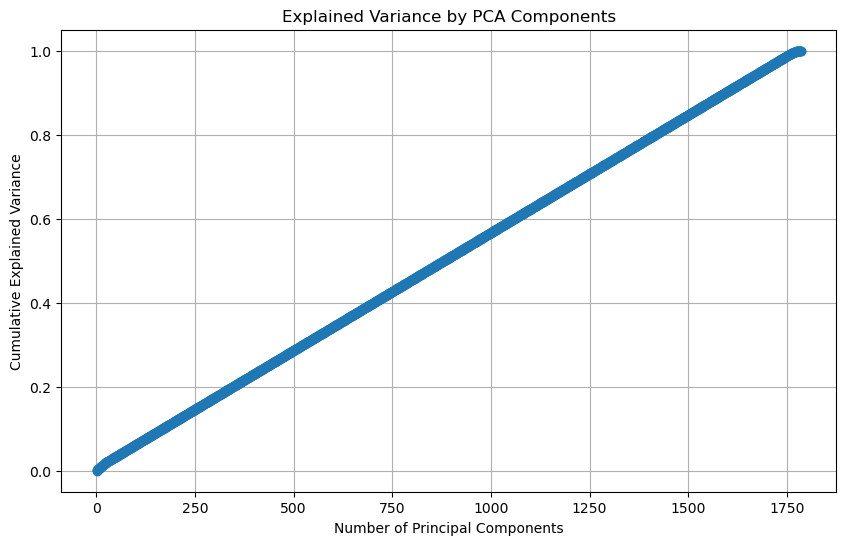

In [14]:
# Drop any non-numeric columns if they exist 
X = X.drop(non_numeric_columns, axis=1)

# Step 1: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Use the explained variance to decide the number of components
explained_variance = pca.explained_variance_ratio_.cumsum()

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

# Step 3: Choose the number of components to keep (e.g., 95% variance)
n_components = sum(explained_variance < 0.95) + 1  # Adjust this threshold as needed
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled)

# X_pca_reduced now contains the reduced data after applying PCA

> **Interpretation - Correlation Plot:**
>  The plot shows a linear relationship (straight line), indicating that each additional principal component we might add, only explains a pretty similar amount of variance as the previous component   
> NOTE: if there were an "elbow point" in the curve/line (ie. where the curve starts to level off), that would mean additional components 
> were actually adding less variance. We would want to stop adding the components at the elbow pt, as those components wouldn't add much to the 
> further analysis

In [ ]:
# View the shape of the reduced dataset
print("Shape of the reduced dataset after PCA:", X_pca_reduced.shape)

# Create a DataFrame from the reduced data
df_pca_reduced = pd.DataFrame(X_pca_reduced, columns=[f'PC{i+1}' for i in range(X_pca_reduced.shape[1])])

# Display the first few rows of the new DataFrame
print("First few rows of the reduced dataset:")
print(df_pca_reduced.head())


> **Interpretation - PCA analysis** : Examining the PCA dataframe that was produced, we get an explanation on Variance: The first few 
> principal components (PC1, PC2, etc.) capture the most significant variance in the data. These components, therefore, are the most important for our
> predictive models.

In [ ]:
# Extract PCA components
pca_components = pd.DataFrame(pca.components_, columns=X.columns)

# Identify the top 2-3 most important features based on the first principal component
most_important_features = pca_components.iloc[0].abs().sort_values(ascending=False).head(3)

# Print the results
print(most_important_features)

**Predictive Analysis RAtionale - We are using Linear Regression for the following reasons:**

* Now that our original input dataset has been feature-reduced (i.e. dimensionality reduction) using the PCA method, we will continue to do our predictive analysis using the Linear Regression model.
* Linear Regression is a good model for this project because of its simplicity, and it can help us understand how different "principal components" (ie. the linear combinations of Genres, Cast, etc.) relate to Movie Ratings.
* We have used the **Ridge Linear Regression** model for our project and data because it includes "regularization" to prevent overfitting, which we have to be especially careful with in our data since we are dealing with so many features.

[https://medium.com/@abelkuriakose/ridge-regression-98c2a65cb3b1#:~:text=It%20is%20a%20regularization%20technique,complex%20and%20overfitting%20the%20data.&text=Here%2C%20%CE%BB%20(lambda)%20is,Ridge%20penalty%20or%20shrinkage%20parameter.]

In [20]:
# Run the predictive Linear model :

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)

# Use a Ridge regression model to fit our data, then train the model:
model = Ridge(alpha=1.0)  # use regularization strength of alpha = 1
model.fit(X_train, y_train)

# Now run prediction on the test set :
y_pred = model.predict(X_test)

# Lastly evaluate the model and run metrics:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 30.21050680011104


> **Interpretation: Model is not performing very well.**

Given that MSE is compares actual target values (y_test, movie rating) to the predicted values (y_pred), a lower MSE indicates that the model's 
predictions are closer to the actual values, while a higher MSE indicates a larger error in predictions. Our MSE value of 30.21 indicates that 
the model is not performing very well, as the errors are relatively large especially since the range of values of our target variable, Movie Rating,
only goes form 1 to 10. 

In [ ]:
# Let's try running a regular Linear Regression Model without any regularization to compare performance :

In [21]:
from sklearn.linear_model import LinearRegression

# Assuming X_pca_reduced is the PCA-reduced data
# Split the PCA-reduced data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)

# Train a simple Linear Regression model on the PCA-reduced data
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Mean Squared Error (Linear Regression): {mse_linear}")



Mean Squared Error (Linear Regression): 2.361588531542235e+19


> **Interpretation: Simple Linear Regression Model performs Extremely Poorly.**
>
> The results from the simple linear regression model are an MSE of 2.361588531542235e+19 (ie. approximately 23.6 quintillion)—is extremely large and indicates that our model is performing every poorly. This extremely large MSE error is likely due to our model being overfit, due to so many columns and insufficient dimension reduction.


**Recommendations** - PCA is a good choice for reducing dimensions but Linear Regression is a poor choice for predictive 
modeling, likely due to overfitting. Random Tree analysis or other models might work better in this regard.
